<a href="https://colab.research.google.com/github/cromcruach52/Snapfolia-Leaf-Detection-and-Classification/blob/main/Leaf_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [5]:
!pip install torch-lr-finder

In [6]:
!pip install split-folders

In [1]:
!pip install seaborn --upgrade

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [1]:
import os
import pandas as pd
import random
import seaborn as sns
import cv2
import torch
import torchvision
import shutil

from PIL import Image
from torch.utils.data import WeightedRandomSampler
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam

import torchvision.models as models
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import splitfolders
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

C:\Users\faith\anaconda3\Lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# I. Data Preparation Phase

In [9]:
split_dataset(leaf_path, output_dir)

Dataset split completed.


In [11]:
leaf_path = "Samples\Leaf_Samples"
output_dir = "Samples\splitted_dataClean"

In [12]:
def sobel_edge_detection(image):
    image = np.array(image)
    channels = []
    for i in range(3):
        gray = image[:, :, i]
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel = np.sqrt(sobelx**2 + sobely**2)
        sobel = np.uint8(sobel)
        channels.append(sobel)
    sobel = np.stack(channels, axis=-1)
    return Image.fromarray(sobel)

class SobelEdgeDetection(object):
    def __call__(self, img):
        return sobel_edge_detection(img)

In [13]:
def to_grayscale(image):
    grayscale_image = image.convert("L")
    grayscale_image = np.stack([np.array(grayscale_image)]*3, axis=-1)
    return Image.fromarray(grayscale_image)

In [14]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.Lambda(to_grayscale),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [15]:
class LeafDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        class_labels = sorted(os.listdir(root_dir))
        for label_idx, label in enumerate(class_labels):
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                for img_path in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_path)
                    self.image_paths.append(img_path)
                    label_vector = [0] * len(class_labels)
                    label_vector[label_idx] = 1
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)

In [16]:
def split_dataset(root_dir, output_dir, test_ratio=0.1, val_ratio=0.2):
    # Creating output directories
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

    for class_dir in class_dirs:
        class_path = os.path.join(root_dir, class_dir)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        random.shuffle(images)

        num_total = len(images)
        num_test = int(num_total * test_ratio)
        num_val = int(num_total * val_ratio)
        num_train = num_total - num_val - num_test

        test_images = images[:num_test]
        val_images = images[num_test:num_test+num_val]
        train_images = images[num_test+num_val:]

        os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_dir, img))

        os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_dir, img))

        os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_dir, img))

    print("Dataset split completed.")

In [17]:
# Load datasets
train = datasets.ImageFolder(root=os.path.join(output_dir, "train"), transform=data_transforms)
val = datasets.ImageFolder(root=os.path.join(output_dir, "val"), transform=data_transforms)
test = datasets.ImageFolder(root=os.path.join(output_dir, "test"), transform=data_transforms)

In [18]:
train_loader = DataLoader(dataset=train,
                             batch_size=32,
                             num_workers=0,
                             shuffle=True,
                             pin_memory=True)

val_loader = DataLoader(dataset=val,
                             batch_size=32,
                             num_workers=0,
                             shuffle=True,
                             pin_memory=True)

test_loader = DataLoader(dataset=test,
                             batch_size=32,
                             num_workers=0,
                             shuffle=False,
                             pin_memory=True)

In [20]:
dataset = LeafDataset(leaf_path, transform=data_transforms)
class_labels = sorted(os.listdir(leaf_path))
print("Class labels:", class_labels)

Class labels: ['Apitong', 'Balete', 'Bayabas', 'Guyabano', 'Kamagong', 'Langka', 'Mahogany', 'Mangga', 'Palo Maria']


In [38]:
def visualize_images_before_after(dataset, transform, num_images=10):
    num_rows = (num_images + 1) // 2
    fig, ax = plt.subplots(num_rows, 4, figsize=(10, 2 * num_rows))

    for i in range(num_images):
        row = i // 2
        col = (i % 2) * 2

        sample_index = random.randint(0, len(dataset) - 1)
        img_path, label = dataset.imgs[sample_index]

        img = Image.open(img_path).convert('RGB')
        ax[row, col].imshow(img)
        ax[row, col].title.set_text(f"Original Image - {class_labels[label]}")

        img_transformed = transform(img)
        img_transformed = img_transformed.permute(1, 2, 0).numpy()
        img_transformed = (img_transformed * 0.229) + 0.485
        img_transformed = img_transformed.clip(0, 1)
        ax[row, col + 1].imshow(img_transformed)
        ax[row, col + 1].title.set_text(f"Processed Image - {class_labels[label]}")

    plt.tight_layout()
    plt.show()

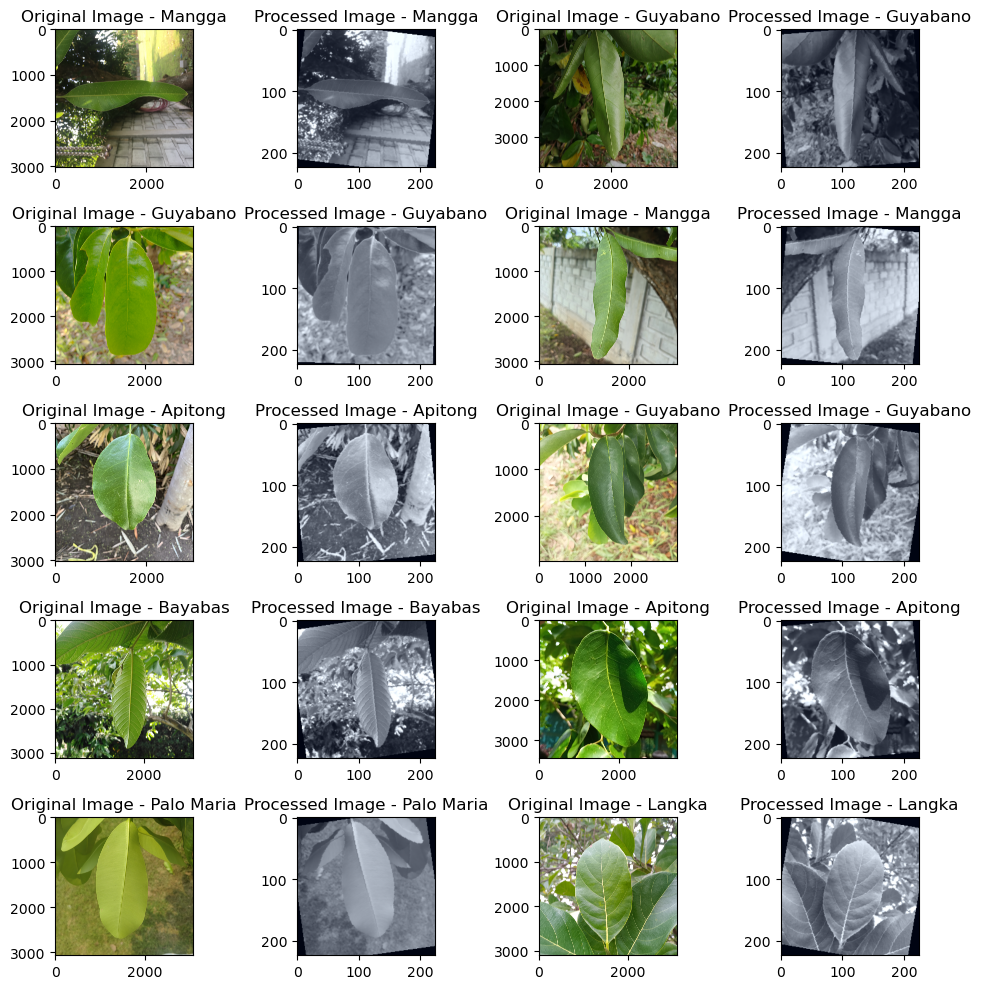

In [39]:
visualize_images_before_after(train, data_transforms, num_images=10)

In [40]:
class_to_idx = train.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Dataset Labels:\n", class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, val, test]):
    images_per_class = pd.Series([class_to_idx[dataset.classes[target]] for target in dataset.targets]).value_counts()
    print(f"Images per Class in {name}:")
    for idx in sorted(images_per_class.index):
        print(f"{idx}    {idx_to_class[idx]}: {images_per_class[idx]}")
    print()

Dataset Labels:
 {'Apitong': 0, 'Balete': 1, 'Bayabas': 2, 'Guyabano': 3, 'Kamagong': 4, 'Langka': 5, 'Mahogany': 6, 'Mangga': 7, 'Palo Maria': 8} 

Images per Class in TRAIN:
0    Apitong: 380
1    Balete: 411
2    Bayabas: 396
3    Guyabano: 364
4    Kamagong: 389
5    Langka: 403
6    Mahogany: 426
7    Mangga: 355
8    Palo Maria: 386

Images per Class in VALIDATION:
0    Apitong: 108
1    Balete: 117
2    Bayabas: 113
3    Guyabano: 107
4    Kamagong: 110
5    Langka: 113
6    Mahogany: 120
7    Mangga: 102
8    Palo Maria: 114

Images per Class in TEST:
0    Apitong: 54
1    Balete: 58
2    Bayabas: 58
3    Guyabano: 53
4    Kamagong: 56
5    Langka: 54
6    Mahogany: 59
7    Mangga: 52
8    Palo Maria: 52



# II. Model Setup Phase

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=models.ResNet50_Weights.DEFAULT)

Using cache found in C:\Users\faith/.cache\torch\hub\pytorch_vision_v0.10.0


In [5]:
for param in resnet.parameters():
    param.requires_grad = False

In [6]:
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 9)

In [7]:
model = resnet.to(device)

# III. Loss Function and Optimizer Setup

In [46]:
num_ftrs = resnet.fc.in_features
num_classes = len(class_labels)

In [47]:
total_samples = len(train)
samples_per_class = [len(os.listdir(os.path.join(leaf_path, label))) for label in class_labels]

print("Samples per class:", samples_per_class)

initial_class_weights = [total_samples / samples_per_class[i] for i in range(len(class_labels))]

class_weights = [np.log1p(weight) for weight in initial_class_weights]

print("Initial class weights:", initial_class_weights)
print("Log-scaled class weights:", class_weights)


weights = torch.tensor(class_weights).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)

Samples per class: [542, 586, 583, 551, 563, 588, 620, 534, 583]
Initial class weights: [6.476014760147602, 5.989761092150171, 6.020583190394511, 6.3702359346642465, 6.234458259325044, 5.969387755102041, 5.661290322580645, 6.573033707865169, 6.020583190394511]
Log-scaled class weights: [2.0116998639289276, 1.944446377142331, 1.9488462901419106, 1.9974497185333833, 1.978855479508722, 1.941527380900218, 1.8963132079159413, 2.0245937411801673, 1.9488462901419106]


In [48]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# IV. Training Phase

In [49]:
def train_model(model, criterion, optimizer, train_loader, val_loader, scheduler, num_epochs=64, patience=5, checkpoint_interval=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    early_stopping_counter = 0
    best_loss = float('inf')
    early_stop = False  

    for epoch in range(num_epochs):
        if early_stop:  
            print('Breaking out of epoch loop due to early stopping.')
            break  

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {lr}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.cuda()
                labels = labels.cuda().long()

                labels = F.one_hot(labels, num_classes=9).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                preds = outputs > 0.5
                corrects = (preds == labels).sum().item()
                running_corrects += corrects
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects / (len(data_loader.dataset) * num_classes)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            if phase == 'val':
                scheduler.step(epoch_loss)  
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    print(f'Early stopping counter: {early_stopping_counter} out of {patience}')
                    if early_stopping_counter >= patience:
                        model.load_state_dict(best_model_wts)
                        print(f'Early stopping triggered.')
                        early_stop = True  
                        break

        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = f'model_checkpoint_epoch_{epoch+1}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved at epoch {epoch+1}')

    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, time_elapsed, best_loss, best_acc

model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc = train_model(
    model, criterion, optimizer, train_loader, val_loader, scheduler, num_epochs=64, patience=5)

torch.save(model.state_dict(), 'final_model.pth')

print("Training finished...\n")


Epoch 1/64
----------
Learning Rate: 0.001
train Loss: 0.4339 Acc: 0.8943
val Loss: 0.3205 Acc: 0.9117
Epoch 2/64
----------
Learning Rate: 0.001
train Loss: 0.2801 Acc: 0.9260
val Loss: 0.2487 Acc: 0.9382
Epoch 3/64
----------
Learning Rate: 0.001
train Loss: 0.2302 Acc: 0.9427
val Loss: 0.2123 Acc: 0.9488
Epoch 4/64
----------
Learning Rate: 0.001
train Loss: 0.1976 Acc: 0.9523
val Loss: 0.1836 Acc: 0.9588
Epoch 5/64
----------
Learning Rate: 0.001
train Loss: 0.1785 Acc: 0.9575
val Loss: 0.1717 Acc: 0.9620
Checkpoint saved at epoch 5
Epoch 6/64
----------
Learning Rate: 0.001
train Loss: 0.1665 Acc: 0.9611
val Loss: 0.1601 Acc: 0.9634
Epoch 7/64
----------
Learning Rate: 0.001
train Loss: 0.1564 Acc: 0.9644
val Loss: 0.1514 Acc: 0.9633
Epoch 8/64
----------
Learning Rate: 0.001
train Loss: 0.1450 Acc: 0.9670
val Loss: 0.1387 Acc: 0.9683
Epoch 9/64
----------
Learning Rate: 0.001
train Loss: 0.1392 Acc: 0.9679
val Loss: 0.1366 Acc: 0.9707
Epoch 10/64
----------
Learning Rate: 0.001
t

In [50]:
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report

def test_model(model, test_loader, device, class_labels):
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            all_predictions.extend(predicted.to("cpu").numpy())
            all_labels.extend(outputs.to("cpu").numpy())

    # Convert predictions and labels to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Individual models
    models = [
        ('svm', SVC()),
        ('knn', KNeighborsClassifier()),
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
    ]

    for name, model in models:
        model.fit(all_predictions.reshape(-1, 1), all_labels)
        preds = model.predict(all_predictions.reshape(-1, 1))
        print(f"{name.upper()} Classification Report:")
        print(classification_report(all_labels, preds, target_names=class_labels, zero_division=1))

    # Voting Classifier
    voting_model = VotingClassifier(estimators=models, voting='hard')
    voting_model.fit(all_predictions.reshape(-1, 1), all_labels)
    voting_preds = voting_model.predict(all_predictions.reshape(-1, 1))
    print("Voting Classifier Classification Report:")
    print(classification_report(all_labels, voting_preds, target_names=class_labels, zero_division=1))

# Call the function to test the models
test_model(model, test_loader, device, class_labels)

SVM Classification Report:
              precision    recall  f1-score   support

     Apitong       0.93      0.78      0.85        54
      Balete       0.93      0.95      0.94        58
     Bayabas       0.93      0.95      0.94        58
    Guyabano       0.75      0.92      0.83        53
    Kamagong       0.96      0.77      0.85        56
      Langka       0.86      0.93      0.89        54
    Mahogany       0.88      0.90      0.89        59
      Mangga       0.98      0.94      0.96        52
  Palo Maria       0.93      0.98      0.95        52

    accuracy                           0.90       496
   macro avg       0.91      0.90      0.90       496
weighted avg       0.91      0.90      0.90       496

KNN Classification Report:
              precision    recall  f1-score   support

     Apitong       0.43      0.87      0.57        54
      Balete       0.93      0.95      0.94        58
     Bayabas       0.48      0.98      0.64        58
    Guyabano       1.00 

In [21]:
def test_model():
    model = models.resnet50(weights = None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 9)

    model = model.to(device)
    model.load_state_dict(torch.load("final_model.pth"))
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            all_predictions.extend(predicted.to("cpu").numpy())
            all_labels.extend(outputs.to("cpu").numpy())

    print("Test Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_labels))

    # Return a flattened array of all predictions
    return np.array(all_predictions).flatten()

# Call the function to test the model
all_preds = test_model()

Test Classification Report:
              precision    recall  f1-score   support

     Apitong       0.93      0.70      0.80        54
      Balete       0.92      0.97      0.94        58
     Bayabas       0.92      0.95      0.93        58
    Guyabano       0.83      0.92      0.88        53
    Kamagong       0.96      0.84      0.90        56
      Langka       0.86      0.93      0.89        54
    Mahogany       0.89      0.92      0.90        59
      Mangga       1.00      0.88      0.94        52
  Palo Maria       0.85      1.00      0.92        52

    accuracy                           0.90       496
   macro avg       0.91      0.90      0.90       496
weighted avg       0.91      0.90      0.90       496



In [ ]:
def plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc):
    # Plot accuracy
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Print training time and best metrics
    print(f'Best val Loss: {best_loss:.4f}')
    print(f'Best val Acc: {best_acc:.4f}')

plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc)

In [ ]:
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(cm, cmap="Blues", annot=True, fmt=".2f", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix", size=20)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
model.eval()

true_labels = []
predicted_labels = []
misclassified_indices = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        
        for j in range(len(labels)):
            if preds[j] != labels[j]:
                misclassified_indices.append((i * test_loader.batch_size) + j)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

print(f"Number of misclassified images: {len(misclassified_indices)}")

num_images_to_show = min(10, len(misclassified_indices))  
plt.figure(figsize=(20, 10))
for idx, misclassified_index in enumerate(misclassified_indices[:num_images_to_show]):
    
    image, true_label = test_loader.dataset[misclassified_index]
    predicted_label = predicted_labels[misclassified_index]
    
 
    plt.subplot(2, 5, idx + 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())  
    plt.title(f"True: {class_labels[true_label]}, Pred: {class_labels[predicted_label]}")
    plt.axis('off')

plt.show()

In [ ]:
def load_model(model_path, num_classes=9):
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

def image_predict(image_path, model, transform, class_labels, threshold=0.5):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image)
        probs = torch.sigmoid(outputs).numpy().flatten()

        for i, prob in enumerate(probs):
            print(f"{class_labels[i]}: {prob:.4f}")

        confidence_levels = {class_labels[i]: float(probs[i]) for i in range(len(class_labels))}

        highest_prob = np.max(probs)
        highest_class = class_labels[np.argmax(probs)]

        if highest_prob < threshold:
            return f"Uncertain: {highest_class} with confidence {highest_prob:.2f}", confidence_levels

        return highest_class, highest_prob

model_path = 'final_model.pth'
model = load_model(model_path, num_classes=len(class_labels))

image_path = 'Samples/Testing/Balayong (2).jpg'
prediction, confidence = image_predict(image_path, model, data_transforms, class_labels)

print("Predicted class:", prediction)
print("Confidence level:", confidence)